## Digital Epidemiology - Assignment 1
### Group Members: 
   - Viger Durand Azimedem Tsafack (1792126)
   - Pratuat Amatya (1800063)
   - Malick Alexandre Ngorovitch Sarr (1788832)

#### Importing all the usefull libraries

In [2]:
import pandas as pd 
import datetime
from os import listdir
from os.path import isfile, join
from tabula import read_pdf
from tqdm import tqdm
from mwviews.api import PageviewsClient
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, ARDRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sb
%matplotlib inline

#### 1.1 - Fetch the weekly aggreagate paviews information from wikipedia
We want to collect from wikipedia the weekly pageviews information for the "Influenza" page and other related pages selected based on their relationship with influenza disease.
            
            e.g: "Febbre" page was selected because it is a symptom of influenza.
            
The goal is to compare the wikipedia pageviews time series with ground truth time series (Influnet). Let's start by gathering the pageviews data for all the pages of interest at once (for the seek of rapidity). We processed the Wikipedia pageview data for the "Influenza" page of the Italian Wikipedia (https://it.wikipedia.org/wiki/Influenza), aggregated the pageviews on a weekly time scale. We divided our collections procedures into two parts. First, we collected the wiki pages related to the symptoms of Influenza then we went ahead and collected the pages related to the treatment and prevention of influenza virus. Both symptoms and treatments wiki pages were used starting from the Influenza page in Wikipedia.

The data was extracted using the wiki API python package mwviews which allowed us to extract daily pageviews data starting from July 2015 to November 2018. Please note that the views from the raw data provided to us start from 2015. The daily views were aggregated to weekly views with the date format: 2016-46(Year - Week Number).

In [3]:
syntomes = ['Influenza','Influenzavirus_A', 'Febbre', 'Rinorrea', 'Cefalea', 'Vomito', 'Starnuti', 'Mal_di_testa', 'Artralgia',
            'Faringite', 'Bronchite', 'Polmonite','Tosse','Lacrima', 'Cianosi']
medicines = ['Paracetamolo', 'Aspirina', 'Antivirale', 'Feniramina', 'Antibiotico', 'Vaccino_antinfluenzale', 'Ketoprofene']
terms = syntomes + medicines

p = PageviewsClient(user_agent="<person@organization.org> Influenza analysis")
page_views = dict(p.article_views('it.wikipedia', terms, granularity='daily', start='20150701', end='20181208'))
page_views = pd.DataFrame.from_dict(page_views, orient = 'index')
page_views = page_views.reset_index()
page_views = page_views.rename(columns={'index': 'Date'})

new_index = []
for i,d in page_views.iterrows():
  new_index.append((d.Date.isocalendar()[0] , d.Date.isocalendar()[1]))

new_index = pd.Series(new_index)
page_views['Date'] = new_index
page_views = page_views.rename(columns={'Date': 'Year-Week'})

The resulting data is the following and it contains daily pageviews information for our pages starting from 01/07/2015 up to 08/12/2018:

In [4]:
page_views.head(5)

,Year-Week,Influenza,Influenzavirus_A,Febbre,Rinorrea,Cefalea,Vomito,Starnuti,Mal_di_testa,Artralgia,...,Tosse,Lacrima,Cianosi,Paracetamolo,Aspirina,Antivirale,Feniramina,Antibiotico,Vaccino_antinfluenzale,Ketoprofene
0,"(2015, 27)",125,31,437,50,374,229,1.0,12,103,...,110,36,166,556,21,54,6.0,297,24,238
1,"(2015, 27)",100,20,389,53,385,216,1.0,13,108,...,76,35,145,520,26,54,8.0,261,28,225
2,"(2015, 27)",111,16,348,50,303,268,3.0,12,80,...,84,52,150,552,26,62,4.0,262,21,244
3,"(2015, 27)",86,15,342,29,232,240,4.0,9,68,...,55,45,114,511,19,49,9.0,207,6,245
4,"(2015, 27)",106,20,336,37,216,267,3.0,13,50,...,93,29,161,505,22,50,7.0,257,12,209


The analysis is going to be performed on a weekly pageviews basis. Thus, we need to aggregate the above data on a weekly time scale. This is done using the following code: 

In [5]:
page_views = page_views.groupby(['Year-Week'])[terms].agg('sum')
page_views = page_views.reset_index()
page_views = page_views.sort_values(by=['Year-Week'])
page_views['Year-Week'] = page_views['Year-Week'].apply(lambda x: str(x[0]) + '-' + str("{:02d}".format(int(x[1]))))
page_views.insert(page_views.columns.get_loc('Year-Week') + 1, 'Year', 0)
page_views.insert(page_views.columns.get_loc('Year') + 1, 'Week', 0)
page_views['Year'] = list(map(lambda x: int(x.split('-')[0]), page_views['Year-Week']))
page_views['Week'] = list(map(lambda x: int(x.split('-')[1]), page_views['Year-Week']))

Let's give a look at the resulting weekly aggregated data. 

In [6]:
page_views.head(5)

,Year-Week,Year,Week,Influenza,Influenzavirus_A,Febbre,Rinorrea,Cefalea,Vomito,Starnuti,...,Tosse,Lacrima,Cianosi,Paracetamolo,Aspirina,Antivirale,Feniramina,Antibiotico,Vaccino_antinfluenzale,Ketoprofene
0,2015-27,2015,27,528,102,1852,219,1510,1220,12.0,...,418,197,736,2644,114,269,34.0,1284,91,1161
1,2015-28,2015,28,684,137,2706,402,1955,1726,15.0,...,596,253,1343,3727,139,347,32.0,1734,126,1801
2,2015-29,2015,29,679,139,2913,346,2100,1766,18.0,...,682,233,1358,3869,133,324,34.0,1792,173,1806
3,2015-30,2015,30,624,115,2808,323,1684,1655,22.0,...,582,246,1139,7133,184,306,55.0,1680,126,1792
4,2015-31,2015,31,597,84,2416,260,1867,1649,28.0,...,517,214,748,3859,143,308,41.0,1631,92,1800


Now that we have the needed data, let's visualise the time series of our main page ("Ifluenza"). Follows a graph showing the resulting time series of the pageviews for the "Influenza" page. as mentioned before, the time frame is the following:
   - Staring date: 01/07/2015
   - End date:     08/12/2018

In [7]:
page_views["Influenza"].describe()

count     180.000000
mean     1649.311111
std       936.869238
min       282.000000
25%      1066.250000
50%      1421.000000
75%      1962.250000
max      5962.000000
Name: Influenza, dtype: float64

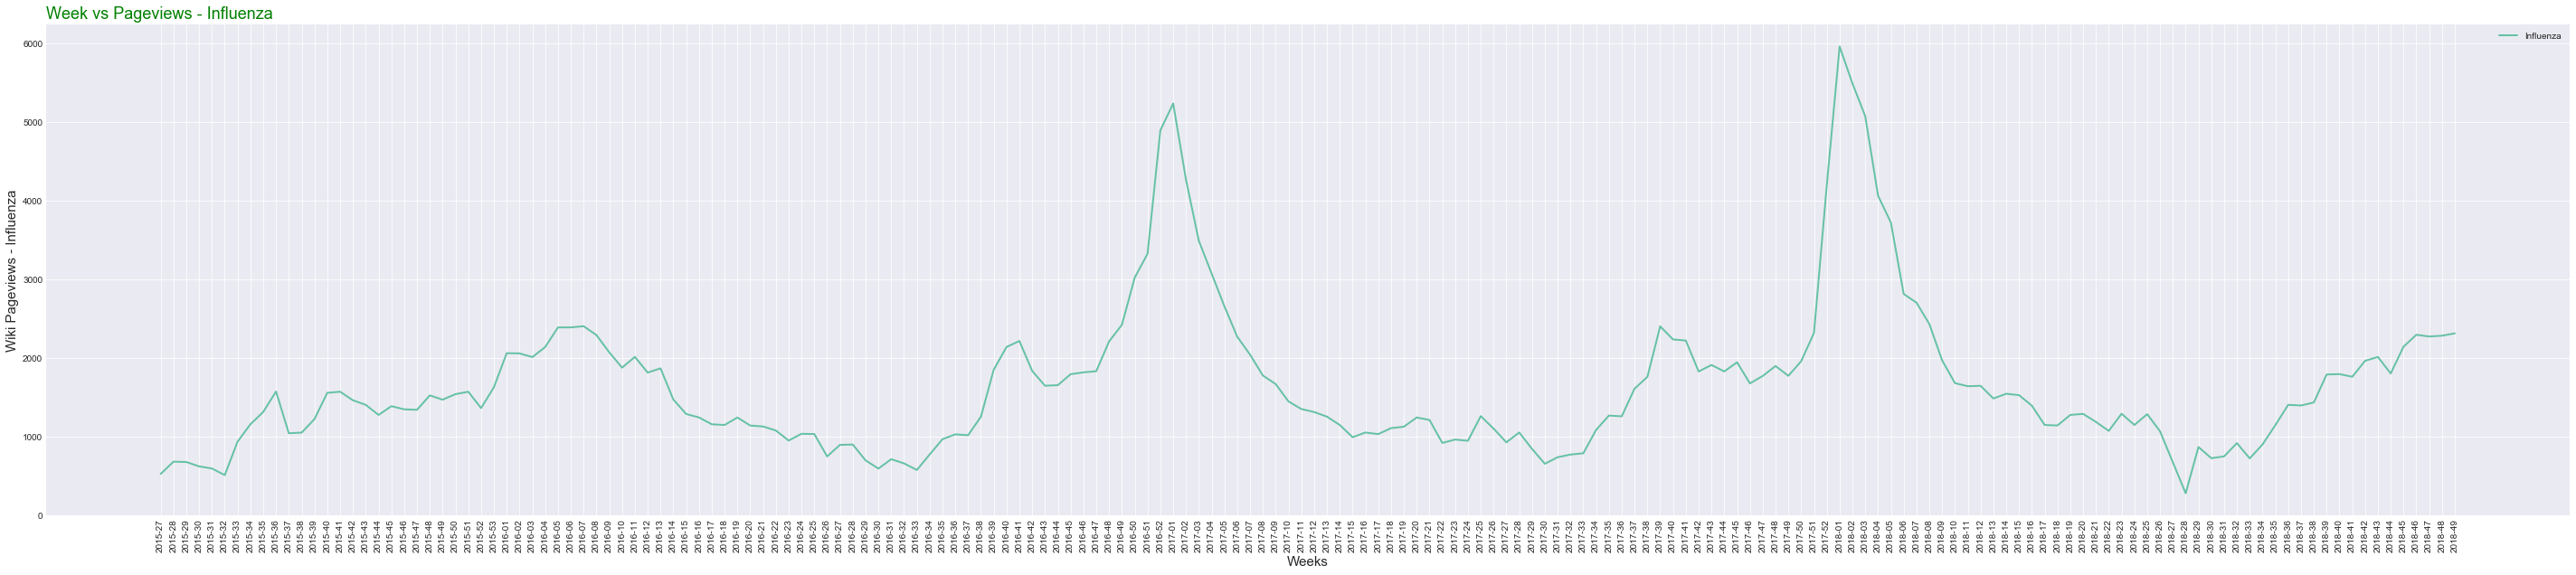

In [8]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')
plt.figure(figsize=(50, 10))
plt.plot(page_views['Year-Week'], page_views['Influenza'], marker='', color=palette(0), linewidth=2, alpha=1, label='Influenza')
plt.legend(loc=1, ncol=1)
plt.title("Week vs Pageviews - Influenza", loc='left', fontsize=18, fontweight=0, color='green')
plt.xlabel('Weeks', fontsize=15)
plt.ylabel('Wiki Pageviews - Influenza', fontsize=15)
plt.xticks(page_views['Year-Week'], rotation='vertical')
plt.show()

Looking at the resulting time series of the page views related to the Influenza page access in Italy, we realize that the values fluctuate around 1500 views per week, with a mean of 251 views per week (on the jupyter notebook, double clicking on the plot allows to see it in details).

The plot shows however two distinctive peaks: both corresponding to the first week of 2017 and 2018 with a peak search set at 5962 and 5238 page views respectively. Ergo, with these two peaks present, we can make an initial assumption that there were cases of influenza recorded those weeks. Additionnally, we can observe that another slight increase in the amount of influenza page access at towards the beginning of year 1. Through these results, we can derive the hypothesis that Influenza in Italy tend to happend at the end and beginning of each year based on the wikipedia Influenza page access and that there exist a correlation between the number of incidences of influenza in Italy, and the number of Influenza Wikipedia page views. Of course, at this point, we need more evidence in order to establish any kind of relations.  

#### 1.2 - Compare the time series from the official Influnet surveillance system with the time series of pageviews obtained in 1.1.
We want to know if analising wikipedia pageviews data for Influenza disease could be similar to the official analysis performed by "influnet" (We consider influnet data as our ground truth). We will compare the above plotted time series of the wikipedia pageviews with the influnet time series from the official influnet data. 

The next step would be to process the official data on influenza in Italy. The available data is provided as PDF files, so we used a python package named tabula-py to extract that data and save it into a CSV file. The official data is comprised of a dozen PDF files recording data on influenza since 2004. Analyzing the structure of the reports, the information of interest is the date along with the estimated flue incidences for that week which corresponds to the 1st and 5th column of the 2nd page of each PDF. The incidence (ground truth) is represented by the number of influenza cases per 1000 assisted for a week. 

Let's fetch the information we need (weeks and total incidence) from the influnet pdf files:

In [57]:
files = [f for f in listdir('influnet/') if isfile(join('influnet/', f))]

influnet_data = pd.DataFrame() 
for e in tqdm(files):
    tab = pd.DataFrame()
    pdf_table = read_pdf('influnet/'+ str(e), pages=[2])
    if e == 'InfluNet - Stagione 2008 - 2009.pdf': 
        pdf_table_page3 = read_pdf('influnet/'+ str(e), pages=[3], pandas_options={'header': None})[:8]
        pdf_table_page3 = pdf_table_page3.drop([5, 7, 9, 11], axis = 1)
        pdf_table_page3.columns = pdf_table.columns
        pdf_table = pdf_table.append(pdf_table_page3, ignore_index=True)
    if 'Settimana' in pdf_table.columns: tab['Week'] = pdf_table['Settimana']
    else: tab['Week'] = pdf_table['Unnamed: 0'][2:]
    if 'Incidenza Totale' in pdf_table.columns: tab['Total incidence'] = pdf_table['Incidenza Totale']
    else: tab['Total incidence'] = pdf_table['Incidenza'][2:]
    influnet_data = influnet_data.append(tab, ignore_index=True)
influnet_data = influnet_data.rename(columns={'Week': 'Year-Week'})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:53<00:00,  3.55s/it]


The extracted influnet data looks like this:

In [58]:
influnet_data.head(5)

,Year-Week,Total incidence
0,2003-42,"0,36"
1,2003-43,"0,47"
2,2003-44,"0,52"
3,2003-45,"0,60"
4,2003-46,"0,59"


Let's convert the values of the "Total incidence" column in decimal tranforming the commas (",") in periods ("."). We then save the collected infunet data into csv file. Saving this data into a csv file can be time saving, avoiding to run the above code every time that we need the influnet data.

In [59]:
influnet_data = influnet_data.fillna(0)
influnet_data['Total incidence'] = influnet_data['Total incidence'].replace({',':'.'},regex=True).apply(pd.to_numeric,1)
influnet_data.to_csv('influnet_data.csv', sep = ',')

The influnet data now looks like this (with the incidence column converted to numeric values):

In [61]:
influnet_data.head(5)

,Year-Week,Total incidence
0,2003-42,0.36
1,2003-43,0.47
2,2003-44,0.52
3,2003-45,0.60
4,2003-46,0.59


Now that we have all the data we need (Wikipedia pageviews data, Influnet time series), we can finally do the comparison between Wiki time series and Influnet time series. We start by performing an "inner join" between the two dataframes on the "Year-Week" column. The result will be representing the records in both dataframe have the same date (date format being Year-Week). This means that records prior to 42-2015 will be disregarded as the Wikipedia API starts from that date. This also means that the week which did not have any influenza incidences will not be recorded at the official data do not record them. In short, we are only going to be keeping common records between the two datasets.

In [62]:
influnet_data = pd.read_csv('influnet_data.csv', sep = ',', index_col = 0)
data = pd.merge(page_views, influnet_data, how='inner', on=['Year-Week'])
data.head(5)

,Year-Week,Year,Week,Influenza,Influenzavirus_A,Febbre,Rinorrea,Cefalea,Vomito,Starnuti,...,Lacrima,Cianosi,Paracetamolo,Aspirina,Antivirale,Feniramina,Antibiotico,Vaccino_antinfluenzale,Ketoprofene,Total incidence
0,2015-42,2015,42,1464,125,3375,524,2322,1728,20.0,...,288,1020,6360,188,336,56.0,2282,591,2285,0.40
1,2015-43,2015,43,1406,158,3363,462,2292,1638,13.0,...,293,1014,6291,249,335,53.0,2443,633,2186,0.50
2,2015-44,2015,44,1278,136,3190,417,2323,1817,12.0,...,259,1124,5965,160,322,58.0,2138,693,2081,0.68
3,2015-45,2015,45,1389,139,3345,494,2556,1854,25.0,...,275,1028,6107,219,365,60.0,2266,859,2161,0.76
4,2015-46,2015,46,1349,135,3142,402,2546,1929,32.0,...,348,1052,5850,185,383,66.0,2344,924,2203,0.88


As we can see above, the column "Total incidence" which represents the influnet data is not in the same scale as all the other columns representing the wikipedia pageviews data. To overcome this issue, we will nomalise all the data by applying the following function.

In [69]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        #result[feature_name] = (df[feature_name] - df[feature_name].mean()) / (max_value - min_value)
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

Let's perform the comaparison between the "Influenza" pageviews data and the "Influnet" incidence data by first normalising and then plotting then on the same figure.

In [70]:
wiki_vs_influnet_Influenza = data[['Influenza', 'Total incidence']]
wiki_vs_influnet_Influenza = wiki_vs_influnet_Influenza.rename(columns={'Influenza': 'Influenza wiki pageviews'})
wiki_vs_influnet_Influenza = wiki_vs_influnet_Influenza.rename(columns={'Total incidence': 'Influnet Total incidence'})
wiki_vs_influnet_Influenza = normalize(wiki_vs_influnet_Influenza)
wiki_vs_influnet_Influenza.insert(0, 'Year-Week', data['Year-Week'])
wiki_vs_influnet_Influenza.head(5)

,Year-Week,Influenza wiki pageviews,Influnet Total incidence
0,2015-42,0.094423,0.000000
1,2015-43,0.082746,0.006974
2,2015-44,0.056976,0.019526
3,2015-45,0.079324,0.025105
4,2015-46,0.071270,0.033473


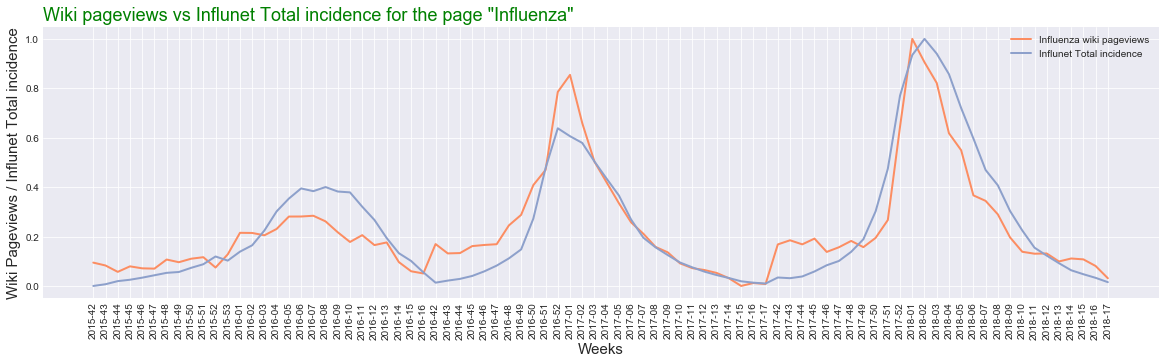

In [71]:
def multiple_line_plot(data):
    # style
    plt.style.use('seaborn-darkgrid')
    # create a color palette
    palette = plt.get_cmap('Set2')
    # Define a figure size
    plt.figure(figsize=(20, 5))

    # multiple line plot
    num = 0
    for column in data.drop('Year-Week', axis=1):
        num += 1
        plt.plot(data['Year-Week'], data[column], marker='', color=palette(num), linewidth=2, alpha=1, label=column)

    # Add legend
    plt.legend(loc=1, ncol=1)
    # Add titles
    plt.xlabel('Weeks', fontsize=15)
    plt.ylabel('Wiki Pageviews / Influnet Total incidence', fontsize=15)
    plt.xticks(data.index, rotation='vertical')
    return plt

plt = multiple_line_plot(wiki_vs_influnet_Influenza)
plt.title("Wiki pageviews vs Influnet Total incidence for the page \"Influenza\"", loc='left', fontsize=18, fontweight=0, color='green')
plt.show()
plt.close()

Observing the above plot, it appears that the two time series of interest are pretty similar. The time periods corresponding to peaks on the graph for the Influnet surveillance system (2016-52, 2017-52, corresponding to winter) also correspond to a peak on the graph for the wikipedia pageviews data. This suggest that the number of views on a the wikipedia "Influenza" page is somehow related to number of people truly having influenza disease in Italy.

To support this assertion, let's compute a measure of correlation between the two time series (Influenza wiki pageviews and Influnet total incidence) using the Pearson method:

In [72]:
corr = wiki_vs_influnet_Influenza.corr(method='pearson', min_periods=1)

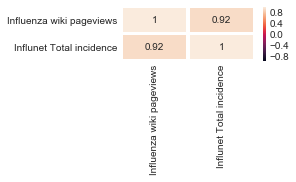

In [73]:
plt.rc("figure", figsize=(3, 1))
sb.heatmap(corr, vmax=1.0, vmin=-1.0 , linewidths=2.5, annot=True)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

In [74]:
corr["Influnet Total incidence"]["Influenza wiki pageviews"]

0.9178363828131869

0.92 is pretty heigh as correlation value so we could conclude that analysing pageviews of "Influenza" page is similar to the work done by the Influnet surveillance system.

#### 2.1 - Check if the other wiki pages related to flu have a pageview time series correlated with the Influnet signal

Now that we observed a pretty high correlation between Influenza page views and the influnet total incidences of influenza, we want to go a step further. We want to see if a similar behaviour can be observed between our alternative pages and the official influnet analysis. We will explore wether or not there exist any high correlation between influnet incidences and the symptoms, medicines or prevention measures of influenza desease.

The alternative pages of interest are the following:

In [75]:
other_pages = terms
other_pages.remove('Influenza')
print(other_pages)

['Influenzavirus_A', 'Febbre', 'Rinorrea', 'Cefalea', 'Vomito', 'Starnuti', 'Mal_di_testa', 'Artralgia', 'Faringite', 'Bronchite', 'Polmonite', 'Tosse', 'Lacrima', 'Cianosi', 'Paracetamolo', 'Aspirina', 'Antivirale', 'Feniramina', 'Antibiotico', 'Vaccino_antinfluenzale', 'Ketoprofene']


Before plotting their time series together with the Influnet signal, we need to normalize them as before in order to put them in the same scale as the Influnet signal.

In [76]:
wiki_vs_influnet_other_pages = data[other_pages + ['Total incidence']]
wiki_vs_influnet_other_pages = wiki_vs_influnet_other_pages.rename(columns={'Total incidence': 'Influnet Total incidence'})
wiki_vs_influnet_other_pages = normalize(wiki_vs_influnet_other_pages)
wiki_vs_influnet_other_pages.insert(0, 'Year-Week', data['Year-Week'])
wiki_vs_influnet_other_pages.head(5)

,Year-Week,Influenzavirus_A,Febbre,Rinorrea,Cefalea,Vomito,Starnuti,Mal_di_testa,Artralgia,Faringite,...,Lacrima,Cianosi,Paracetamolo,Aspirina,Antivirale,Feniramina,Antibiotico,Vaccino_antinfluenzale,Ketoprofene,Influnet Total incidence
0,2015-42,0.071066,0.208233,0.541353,0.532928,0.541781,0.218182,0.164706,0.768240,0.519348,...,0.500000,0.302392,0.124600,0.492424,0.146127,0.250000,0.163420,0.474453,0.754177,0.000000
1,2015-43,0.126904,0.206624,0.385965,0.516325,0.480137,0.090909,0.305882,0.414163,0.450781,...,0.526596,0.296651,0.116104,0.954545,0.144366,0.215909,0.239905,0.512774,0.675418,0.006974
2,2015-44,0.089679,0.183427,0.273183,0.533481,0.602740,0.072727,0.329412,0.553648,0.364562,...,0.345745,0.401914,0.075967,0.280303,0.121479,0.272727,0.095012,0.567518,0.591885,0.019526
3,2015-45,0.094755,0.204210,0.466165,0.662424,0.628082,0.309091,0.517647,0.523605,0.249151,...,0.430851,0.310048,0.093450,0.727273,0.197183,0.295455,0.155819,0.718978,0.655529,0.025105
4,2015-46,0.087986,0.176991,0.235589,0.656890,0.679452,0.436364,0.423529,0.448498,0.235574,...,0.819149,0.333014,0.061807,0.469697,0.228873,0.363636,0.192874,0.778285,0.688942,0.033473


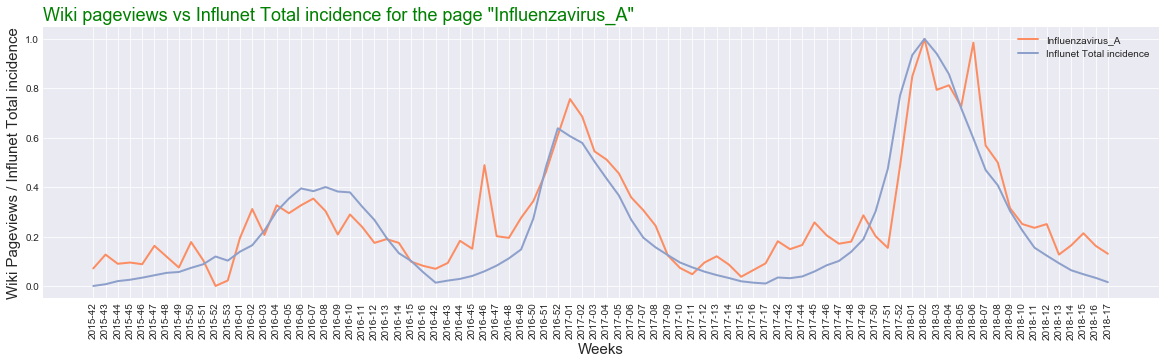

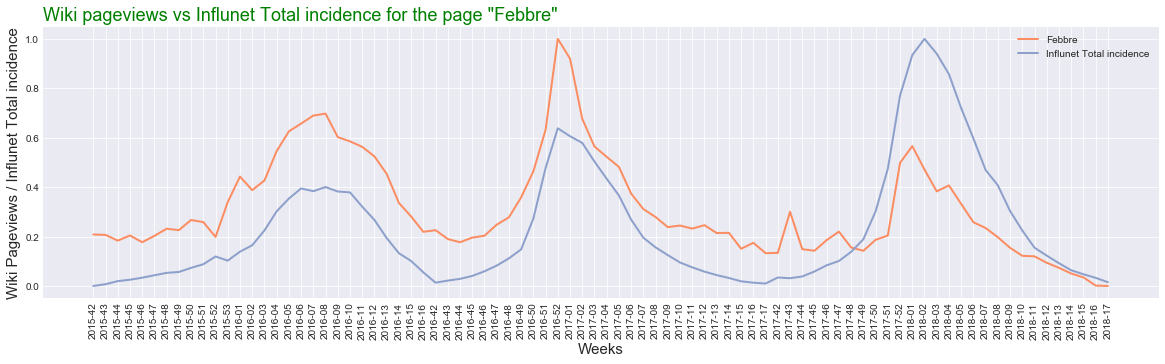

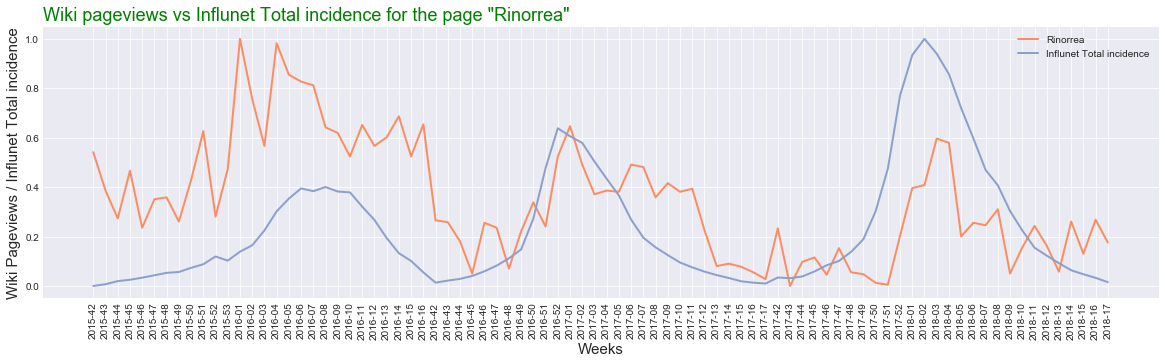

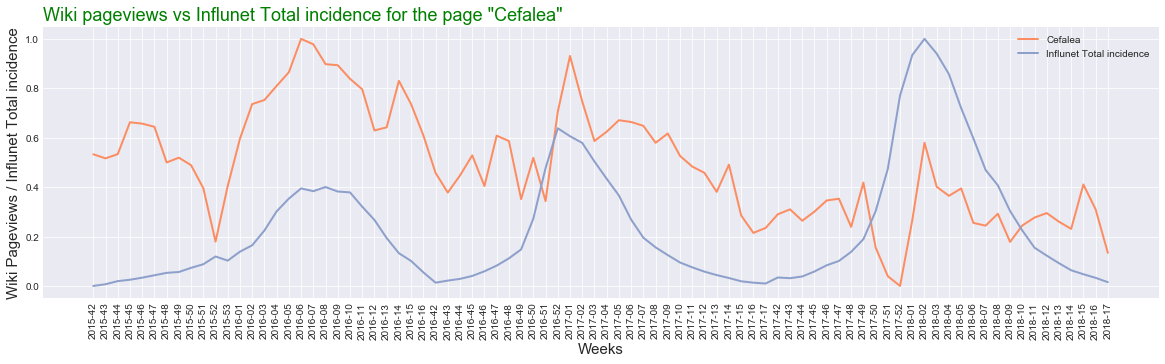

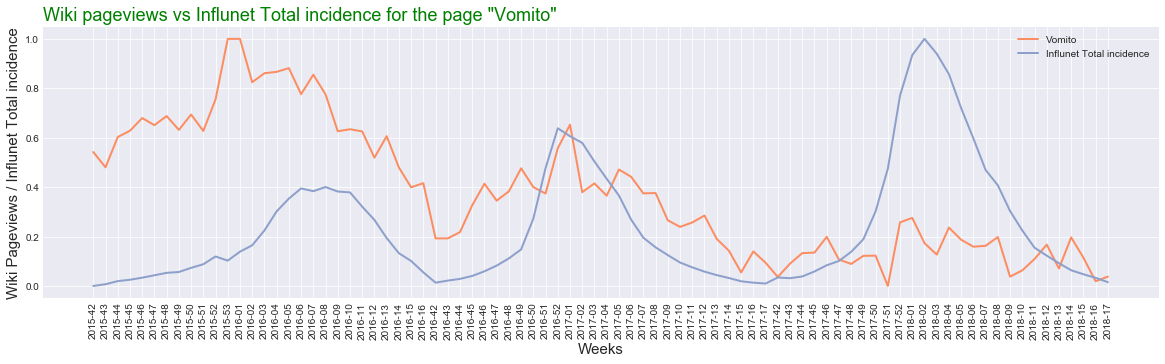

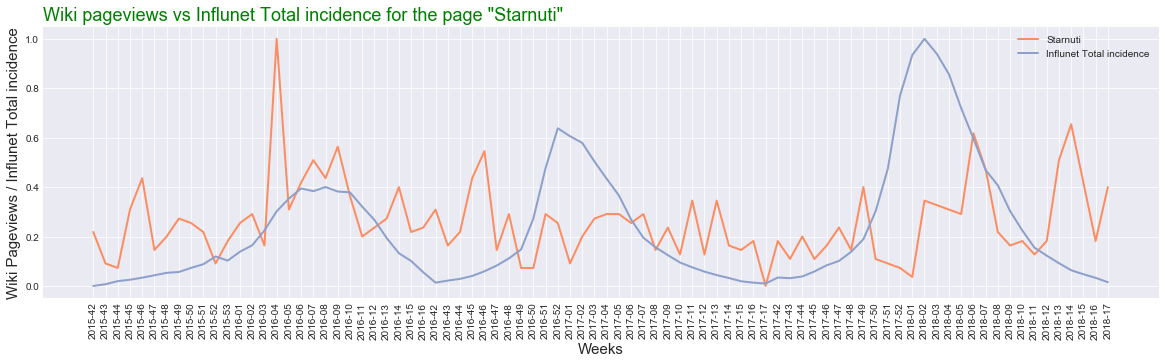

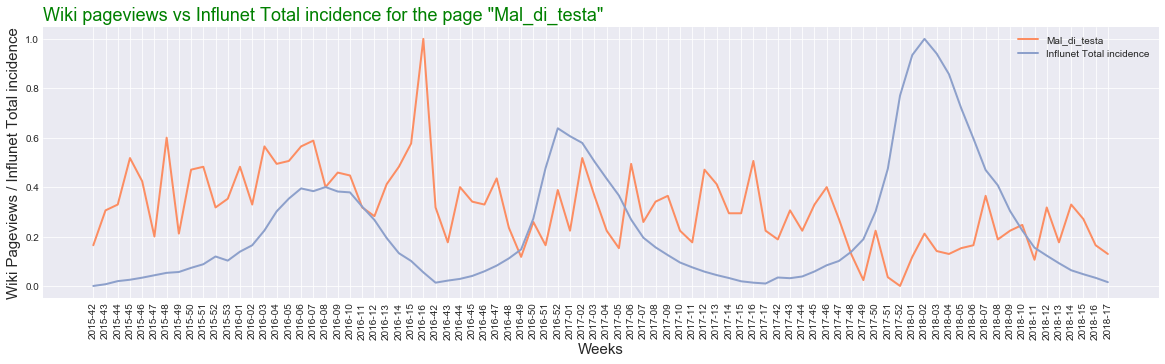

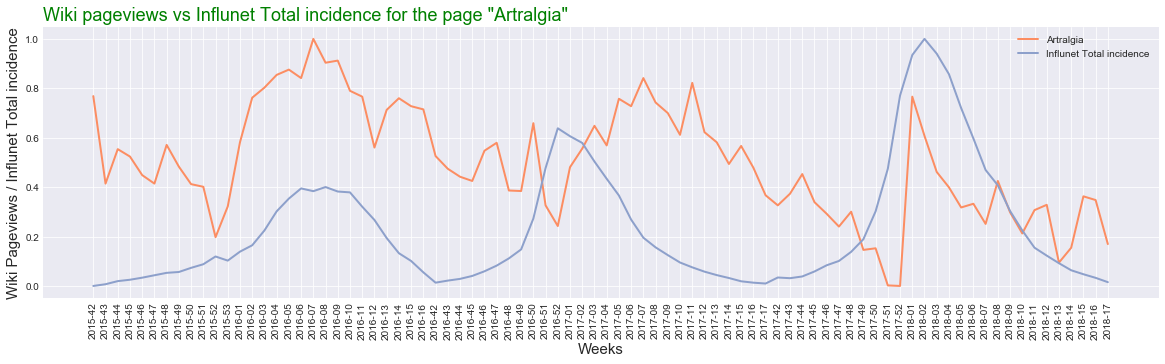

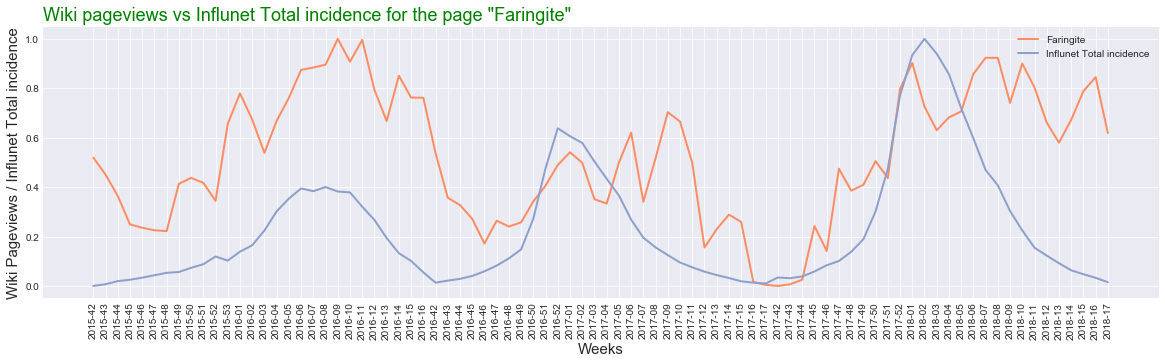

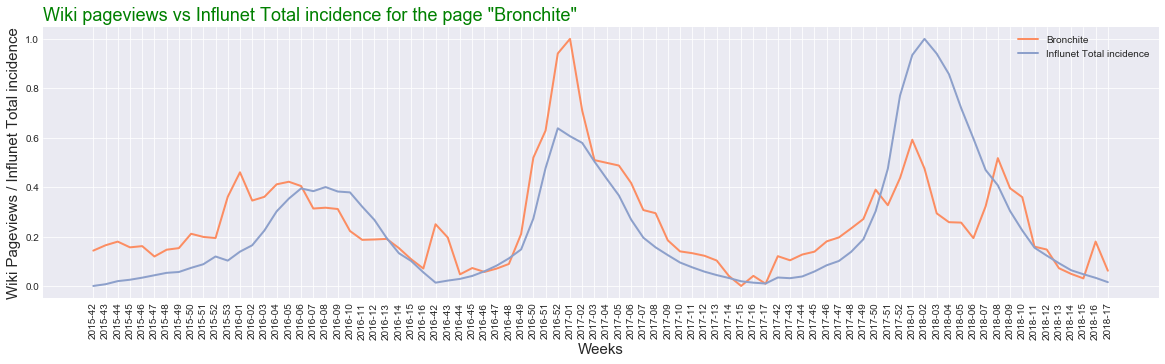

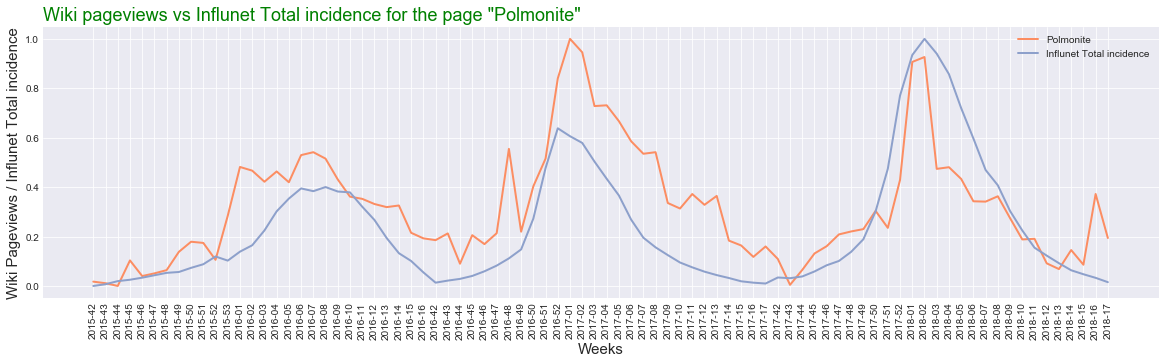

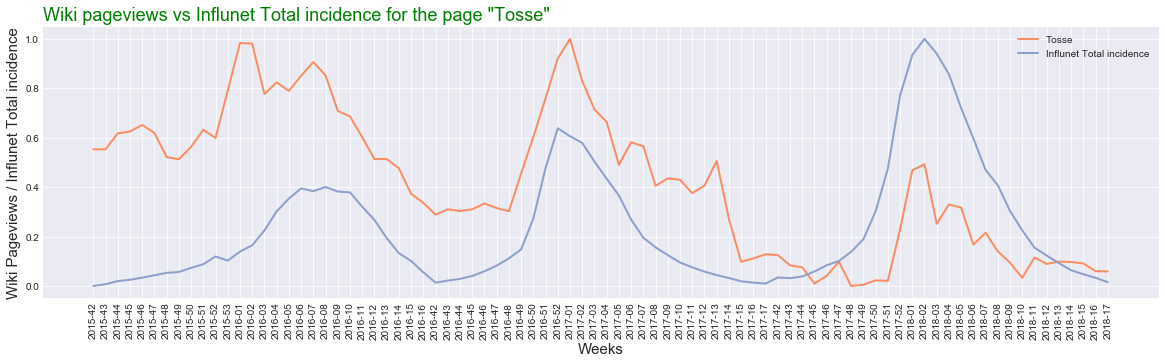

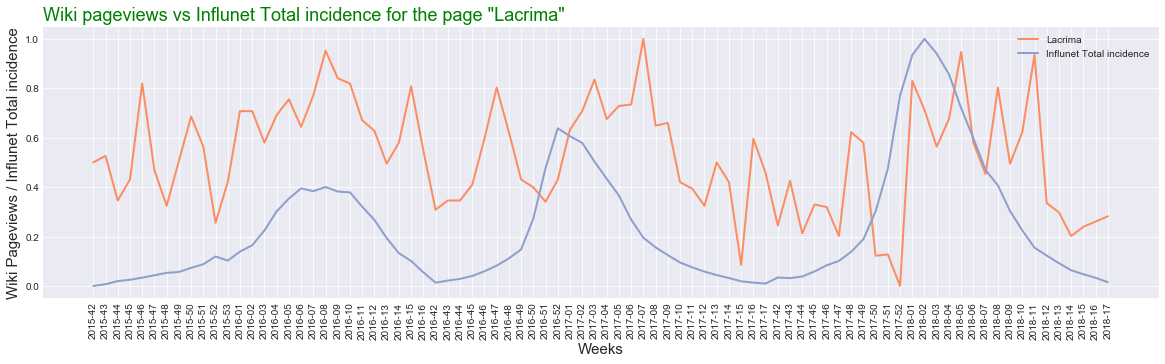

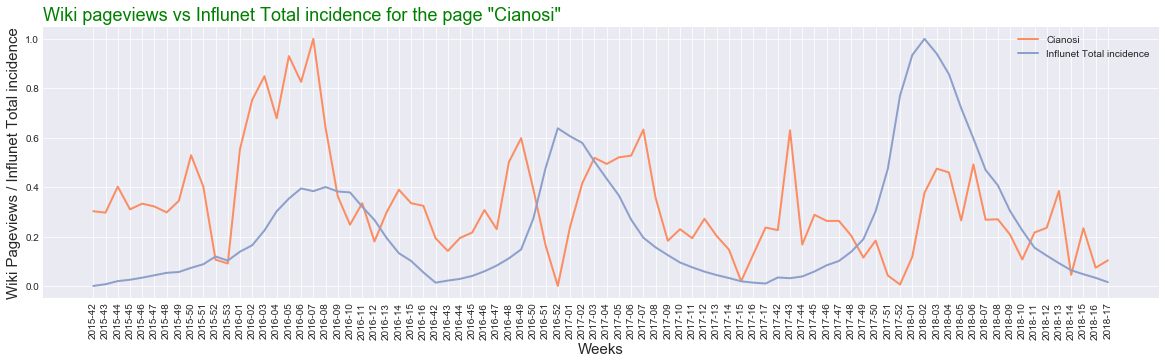

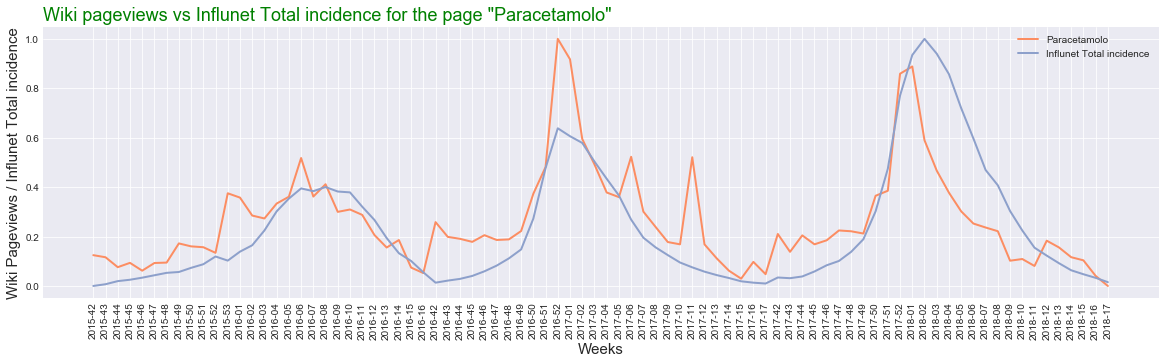

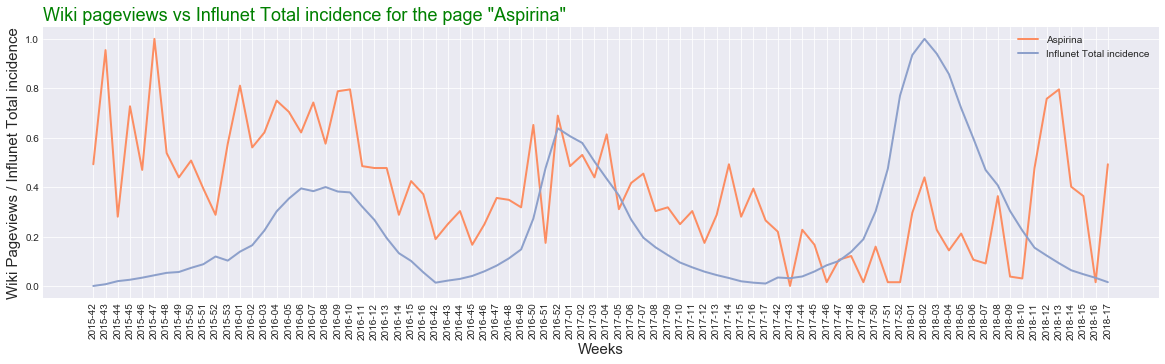

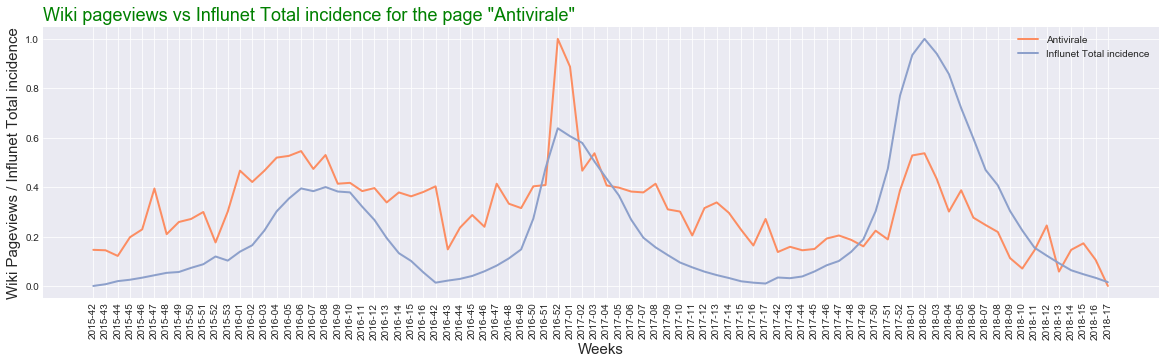

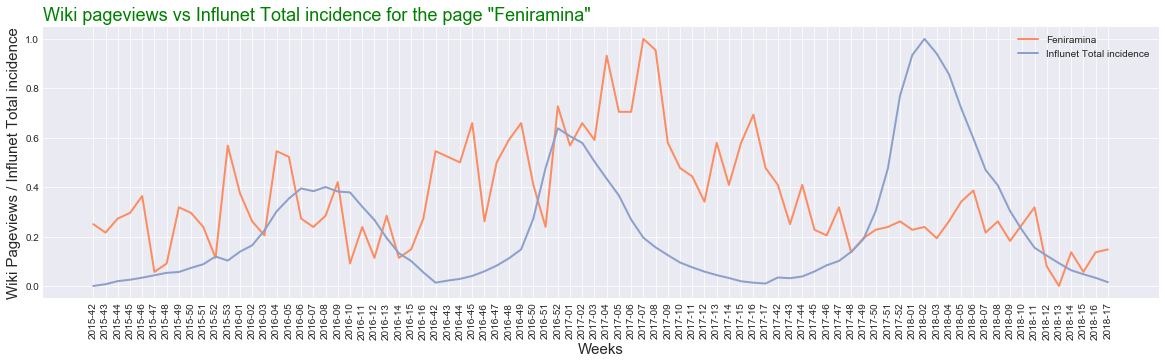

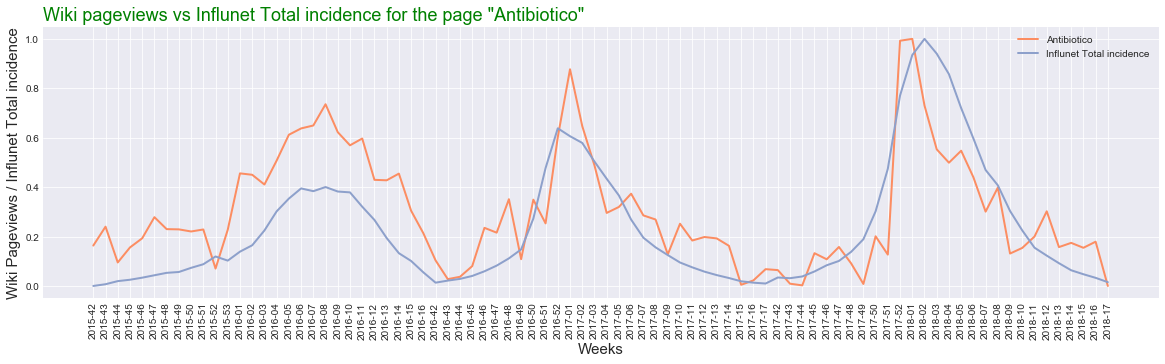

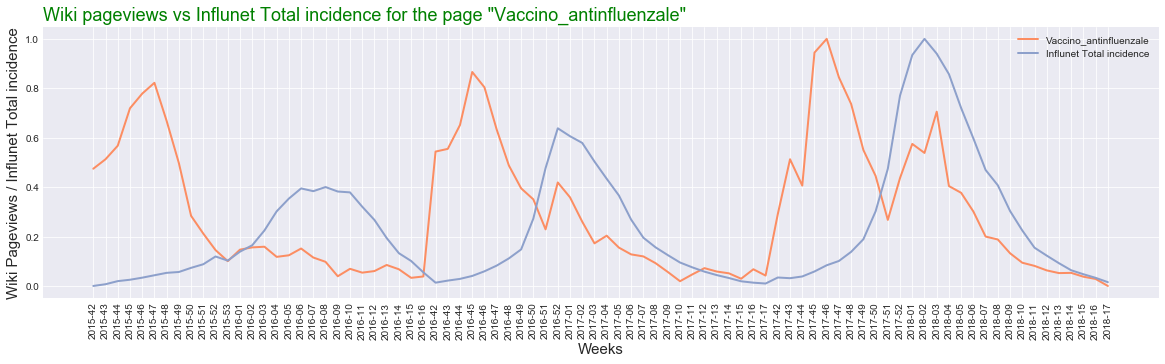

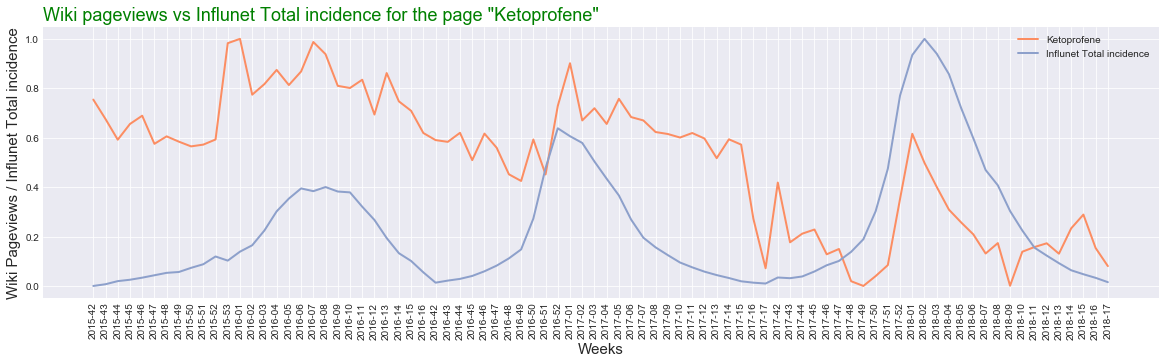

In [77]:
for term in other_pages:
    to_plot = wiki_vs_influnet_other_pages[['Year-Week', term, 'Influnet Total incidence']]
    plt = multiple_line_plot(to_plot)
    plt.title("Wiki pageviews vs Influnet Total incidence for the page \""+term+"\"", loc='left', fontsize=18, fontweight=0, color='green')
    plt.show()
    plt.close()

Looking at the above plots we can say that the pages correlated the most with the influnet signal are the following:

   - Influenzavirus_A
   - Febbre
   - Bronchite
   - Polmonite
   - Paracetamolo
   - Antibiotico

In the folowwing section, we are going to try to confirm this intuition by computing the correlations bettween these pages and the Influnet time series.

#### 2.2 - For each of the selected alternative Wikipedia pages, compute the same correlation with the Influnet time series

In [78]:
corr_other_pages = wiki_vs_influnet_other_pages.corr(method='pearson', min_periods=1)

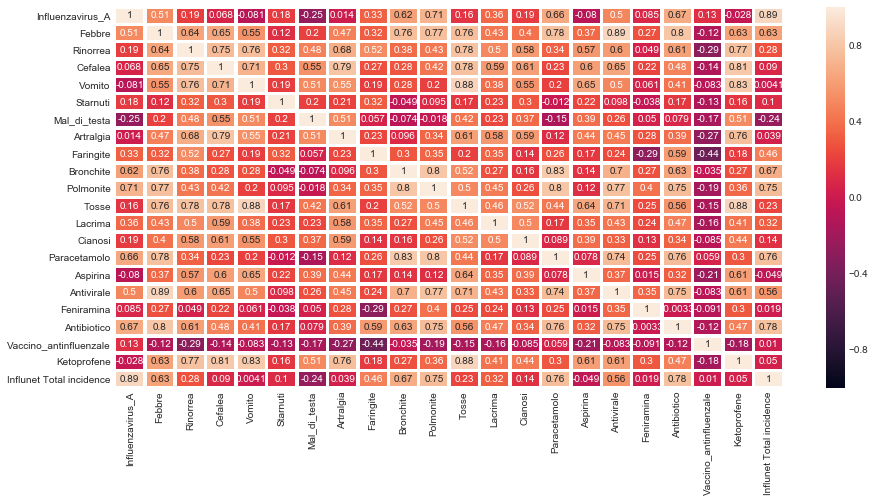

In [79]:
plt.rc("figure", figsize=(15, 7))
sb.heatmap(corr_other_pages, vmax=1.0, vmin=-1.0 , linewidths=2.5, annot=True)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

In [80]:
corr_other_pages["Influnet Total incidence"][other_pages]

Influenzavirus_A          0.893446
Febbre                    0.629790
Rinorrea                  0.280094
Cefalea                   0.089535
Vomito                    0.004123
Starnuti                  0.104172
Mal_di_testa             -0.244705
Artralgia                 0.039068
Faringite                 0.460996
Bronchite                 0.673524
Polmonite                 0.746086
Tosse                     0.225992
Lacrima                   0.324636
Cianosi                   0.137721
Paracetamolo              0.761606
Aspirina                 -0.049031
Antivirale                0.562229
Feniramina                0.018987
Antibiotico               0.779761
Vaccino_antinfluenzale    0.010347
Ketoprofene               0.050251
Name: Influnet Total incidence, dtype: float64

##### 2.2.1 - Which of these correlations are strongest ?

Looking at the above output, it apears that the alternative pages having a relatively strong correlation (>= 0.60) with the Influnet time series are the following:
   - Influenzavirus_A -> 0.893446
   - Antibiotico      -> 0.779761   
   - Paracetamolo     -> 0.761606
   - Polmonite        -> 0.746086
   - Bronchite        -> 0.673524
   - Febbre           -> 0.629790

This only makes sense (conferming the intuition of the previous section) because a person having Influenza would tend to search information about:

   - the virus causing it (Influenzavirus_A)
   - a common symptom like "Febbre"
   - medicines like "Paracetamolo" or "Antibiotico"
   - similar diseases in symptoms like "Bronchite" and "Polmonite"


##### 2.2.1 - Is there any better page than "Influenza" in terms of correlation with the ground truth ?

However, it also apears that none of theses pages is more correlated to the ground truth than our initial "Influenza" page (correlation = 0.92). This could be due to the fact that Influenza desease is easy to recognize and thus people having it will tend to search more about it or about the medicines to cure it (correlation of "Paracetamolo" is 0.828763) rather than searching about the symptoms or similar deseases. 

Another factor could be the fact that sometimes people get all the information needed just by accessing the influenza page. Indeed, the influenza page contains all the information relevant to the disease which include the medicines, the symptomes and prevention measures. Additionnaly, most of the other terms were taken from within the influenza page text. Consequently. it is fair to assume that people access those other pages in order to get more information about a particular other term. Since influenza is our root page, it is an expected behavior to see the influenza page as the one having the strongest correlation with the ground truth.

#### 3.1 - Build a regression model that predicts the Influnet incidence
Now that we have analysed the data, we can attempt to see if it is possible to introduce some case of prediction measure. Indeed, we will attempt to fit a regression model to see if it is is able to accuratelly predict the incidences based on the favious wikipages as features. We will use the lasso linear model as our prediction model. 

The process of creating that model was pretty simple, first we prepared the data by transforming the dataframe into a numpy matrix, splitted the data set with a train set an a test set and finally we fitted the model on the train set before getting the accuracy score from the test set.

In [128]:
# Prepare data
data_reg = data
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data_reg = data_reg[cols]
data_reg = data_reg.drop(['Year-Week'], axis=1)
# Separate features and target variable
y = np.array(data_reg['Total incidence'])
X = np.array(data_reg[data_reg.columns[1:]])
test_size = 0.30
seed = 1788832
# Split data fror cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Linear regression model
model1 = Lasso(alpha=50)
model1.fit(X_train, y_train)
m1_incidence_estimate = model1.predict(X_test)
print ('Linear Model Accuracy: ', model1.score(X_test, y_test))

Linear Model Accuracy:  0.8880484122841716


The above accuracy is pretty good, let's see if we can improve it.

#### 3.2 - Add features to the model

Let's try to improve the model by adding the following features:

- the Influnet incidence for the week preceding the target week
- the pageview counts for all the selected pages (main + alternative pages) for the week preceding the target week

In [129]:
new_data = data.copy()
for page in tqdm(new_data.columns[1:]):
    new_data.insert(new_data.columns.get_loc(page) + 1, 'Prev_week_'+page, 0)
    for row in range(len(new_data[page])):
        if row != 0: new_data.loc[row, 'Prev_week_'+page] = new_data[page][row - 1]
new_data = new_data.drop(['Prev_week_Year', 'Prev_week_Week'], axis = 1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 24.69it/s]


This is how the new data looks like:

In [130]:
new_data.head(5)

,Year-Week,Year,Week,Influenza,Prev_week_Influenza,Influenzavirus_A,Prev_week_Influenzavirus_A,Febbre,Prev_week_Febbre,Rinorrea,...,Feniramina,Prev_week_Feniramina,Antibiotico,Prev_week_Antibiotico,Vaccino_antinfluenzale,Prev_week_Vaccino_antinfluenzale,Ketoprofene,Prev_week_Ketoprofene,Total incidence,Prev_week_Total incidence
0,2015-42,2015,42,1464,0,125,0,3375,0,524,...,56.0,0.0,2282,0,591,0,2285,0,0.40,0.00
1,2015-43,2015,43,1406,1464,158,125,3363,3375,462,...,53.0,56.0,2443,2282,633,591,2186,2285,0.50,0.40
2,2015-44,2015,44,1278,1406,136,158,3190,3363,417,...,58.0,53.0,2138,2443,693,633,2081,2186,0.68,0.50
3,2015-45,2015,45,1389,1278,139,136,3345,3190,494,...,60.0,58.0,2266,2138,859,693,2161,2081,0.76,0.68
4,2015-46,2015,46,1349,1389,135,139,3142,3345,402,...,66.0,60.0,2344,2266,924,859,2203,2161,0.88,0.76


Let's retrain the same model as before with the new data and see if the accuracy improves.

In [131]:
# Prepare data
data_reg = new_data
cols = new_data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data_reg = data_reg[cols]
data_reg = data_reg.drop('Year-Week', axis = 1)
# Separate features and target variable
y = np.array(data_reg['Total incidence'])
X = np.array(data_reg[data_reg.columns[1:]])
test_size = 0.30
seed = 1788832
# Split data fror cross validation
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# Linear regression model
model2 = Lasso(alpha=50)
model2.fit(X_train, y_train)
m2_incidence_estimate = model2.predict(X_test)
print ('Linear Model Accuracy: ', model2.score(X_test, Y_test))

Linear Model Accuracy:  0.917157372781124


Adding the prementioned features actually improved the model from accuracy value of 0.88 to 0.92. 0.92 is pretty good for a model based only on 84 observations with a dimentionality as high as 48. let's visualize this by plotting on the same figure the data estimated by model1, the data estimated by model2 and the groud truth data (influnet data).

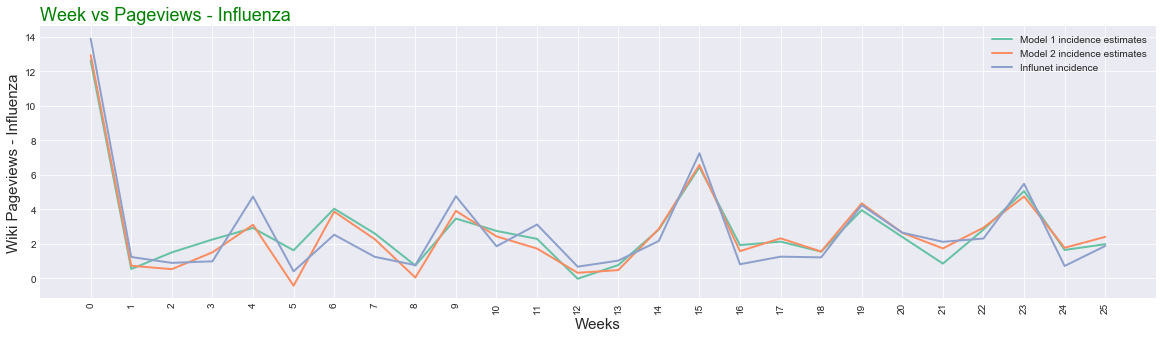

In [136]:
to_plot = pd.DataFrame()
to_plot['m1_incidence_estimate'] = m1_incidence_estimate
to_plot['m2_incidence_estimate'] = m2_incidence_estimate
to_plot['influnet_incidence'] = Y_test
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')
plt.figure(figsize=(20, 5))
plt.plot(to_plot.index, to_plot['m1_incidence_estimate'], marker='', color=palette(0), linewidth=2, alpha=1, label='Model 1 incidence estimates')
plt.plot(to_plot.index, to_plot['m2_incidence_estimate'], marker='', color=palette(1), linewidth=2, alpha=1, label='Model 2 incidence estimates')
plt.plot(to_plot.index, to_plot['influnet_incidence'], marker='', color=palette(2), linewidth=2, alpha=1, label='Influnet incidence')
plt.legend(loc=1, ncol=1)
plt.title("Week vs Pageviews - Influenza", loc='left', fontsize=18, fontweight=0, color='green')
plt.xlabel('Weeks', fontsize=15)
plt.ylabel('Wiki Pageviews - Influenza', fontsize=15)
plt.xticks(to_plot.index, rotation='vertical')
plt.show()

The above plot only confirms that the orange line (model 2: after adding the new features) fits better the blue line (influnet data: ground truth) than the green line (model 1: without the additional features).

## General conclusion

Wikimedia company provides open source data that can be used to simplify today's state of arts analysis. Indeed our goal here was to discover if we can take advantage of this freely available data to predict in near real time the Influnet total incidence values for a given year and week of the iso calendar. We have been able to successfully achieve this goal by accurately (accuracy of 0.92) predicting the Influnet incidence based on the wikipedia's pageviews for the "Influenza" and other related pages. Hence, as a closure sentence we could say that daily web generated data could be exploited to improve significantly our everyday's life.